In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

# Plotting discovery

In [2]:
## Function for converting the absorbance to concentration
def concentration(value):
    concentration = ((value-0.0051)/68.62)*1000
    return concentration

In [31]:
data = pd.read_csv("../data/master_results.csv")

In [4]:
data["concentration"] = data["Mean Absorbance"].apply(concentration)

In [5]:
max_abs_list = []
number_above_ten_running = []
for round in data["Round Number"].unique():
    round_data = data[data["Round Number"] == round]["concentration"]
    max_abs = max(round_data)
    max_abs_list.append(max_abs)

    number_above_ten = np.sum(round_data >= 10)
    number_above_ten_running.append(number_above_ten)

In [6]:
def running_max(lst):
    max_so_far = float('-inf')  # Initialize to negative infinity
    result = []
    
    for num in lst:
        max_so_far = max(max_so_far, num)  # Update the max value seen so far
        result.append(max_so_far)  # Append it to the result list
    
    return result

def running_total(lst):
    total = 0
    result = []
    
    for num in lst:
        total += num  # Add the current number to the running total
        result.append(total)  # Store the running total in the result list
    
    return result

In [7]:
max_conc = running_max(max_abs_list)
number_disc = running_total(number_above_ten_running)

In [8]:
data_combined = pd.DataFrame([max_conc, number_disc]).T

### Figure 2a

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_55989/3240276600.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), size = 18)


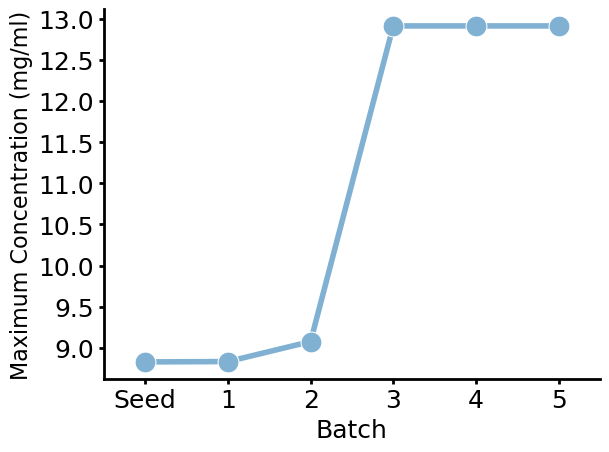

In [9]:
g = sns.lineplot(data_combined[0], marker="o", markersize=15, c = sns.color_palette("Set3")[4], clip_on = False, linewidth = 4)

g.set_xticks([0,1,2,3,4,5])
g.set_xticklabels(["Seed",1,2,3,4,5])
    
g.set_xlabel("Batch", size = 18)

g.set_ylabel("Maximum Concentration (mg/ml)", size = 16)

    #g.set_ylim(-1, -0.35)
g.set_xlim(-0.5, 5.5)
g.set_xticklabels(g.get_xticklabels(), size = 18)
g.set_yticklabels(g.get_yticklabels(), size = 18)

plt.setp(g.spines.values(), linewidth=2)
g.tick_params(width=2)

sns.despine()
plt.savefig("Max_discovered_concentration.pdf")

### Figure 2b

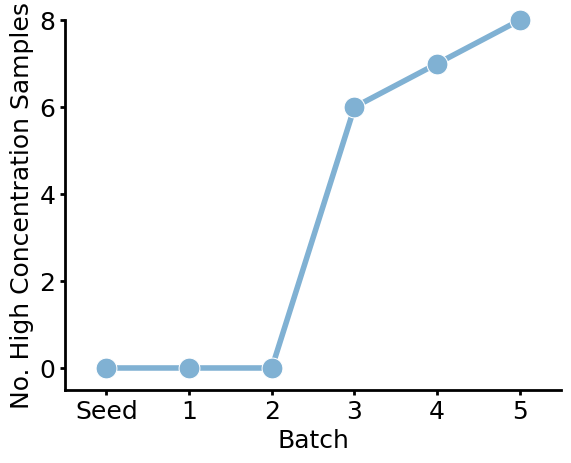

In [10]:
g2 = sns.lineplot(data_combined[1], marker="o", markersize=15, c = sns.color_palette("Set3")[4], clip_on = False, linewidth = 4)

g2.set_xticks([0,1,2,3,4,5])

g2.set_xticklabels(["Seed",1,2,3,4,5])

g2.set_ylim(-0.5, 8)
g2.set_xlim(-0.5, 5.5)
g2.set_xlabel("Batch", size = 18)

g2.set_ylabel("No. High Concentration Samples", size = 18)

g2.set_xticklabels(g2.get_xticklabels(), size = 18)
g2.set_yticks([0,2,4,6,8])
g2.set_yticklabels([0,2,4,6,8], size = 18)

plt.setp(g2.spines.values(), linewidth=2)
g2.tick_params(width=2)

sns.despine()
plt.savefig("No_high_conc_samples.pdf")

# Explore the generated data

In [11]:
import GPyOpt
import itertools

In [12]:
excipient_columns= ["T20", "T80", "P188", "DMSO", "PG"]

high_solubility_samples = data[data["concentration"] >= 10]
high_solubility_samples = high_solubility_samples[excipient_columns]

In [13]:
params = {"T20" : range(0,6, 1),
"T80" : range(0,6, 1),
"P188" : range(0,6, 1),
"DMSO" : range(0,6, 1),
"PG" : range(0,6, 1)}

keys = list(params)

x_values = []

for values in itertools.product(*map(params.get, keys)):
    x_values.append(values)

state_space = pd.DataFrame(x_values, columns= excipient_columns)

In [14]:
## Define the domain and parameters
domain =[{'name': 'T20', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'T80', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'P188', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'DMSO', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'PG', 'type': 'discrete', 'domain': (0,1,2,3,4,5)}]

## Define X and Y values
X_input = np.array(data[excipient_columns])
y_input = np.array(-data["Mean Absorbance"])
y_input = y_input.reshape(len(y_input),1)

## Fit the model to the parameters in the same way we did during the optimisation
bo_model = GPyOpt.methods.BayesianOptimization(f = None, domain = domain, X = X_input, Y = y_input, acquisition_type='EI'
                                        ,evaluator_type="thompson_sampling", batch_size=32, de_duplication=True)

In [15]:
## This initialises the model
x_next = bo_model.suggest_next_locations().astype(int)

In [16]:
y_predictions = bo_model.model.predict(np.array(state_space))[0].flatten()

## Predict the shape of the distribution of possible samples

In [17]:
dosing_predictions = []
for item in y_predictions:
    newitem = -concentration(item)
    dosing_predictions.append(newitem)

## Supplementary figure 1

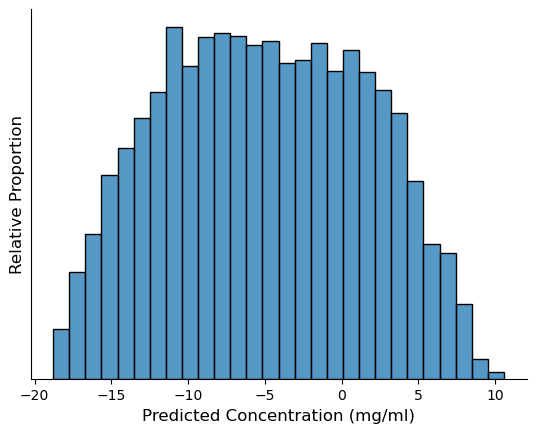

In [18]:
g = sns.histplot(dosing_predictions)
g.set_xlabel("Predicted Concentration (mg/ml)", size = 12)
g.set_ylabel("Relative Proportion", size = 12)
g.set_yticks([])
sns.despine()

## Generate Umap for visualisation of predictions

In [19]:
final_solutions = []

for title, row in high_solubility_samples.iterrows():
    index = state_space.index[(state_space[excipient_columns] == row).all(axis=1)][0]
    final_solutions.append(index)

<Axes: xlabel='0', ylabel='1'>

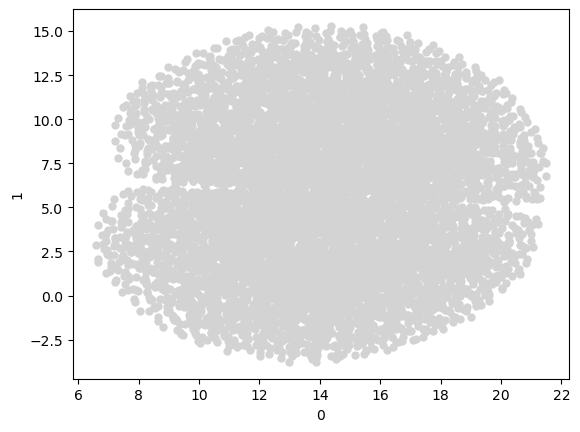

In [20]:
umap_data = pd.read_csv("./Embedding_5variables_seed123.csv", index_col="Unnamed: 0")

## This is a pre calculated set of embeddings for all possible samples
sns.scatterplot(x = umap_data["0"], y = umap_data["1"], c = "lightgrey", lw = 0)

### Figure 2e

Text(6.5, -2.5, 'Umap 2')

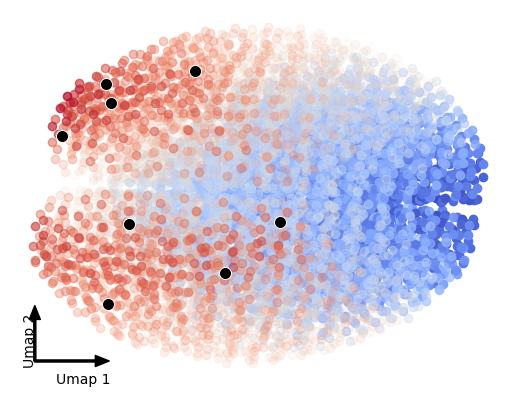

In [24]:
fig, ax = plt.subplots()

norm = plt.Normalize(np.array(y_predictions).min(),np.array(y_predictions).max())
cmap = sns.color_palette("coolwarm_r", as_cmap=True)

# Plot each point manually
testlist = []

for i, (x, y, alpha) in enumerate(zip(umap_data["0"], umap_data["1"], np.clip([(ele) for ele in y_predictions], 1,-1))):
    color = cmap(norm(y_predictions[i]))
    plt.scatter(x, y, color=color, alpha = np.clip(abs(y_predictions[i]), 0,1))

    testlist.append([y, y_predictions[i]])

sns.scatterplot(x = umap_data["0"][final_solutions], y = umap_data["1"][final_solutions], zorder = 10, c = "k", s = 75)

# Remove the axes
ax.axis('off')

# Add small x and y arrows in the bottom left corner
arrowprops = dict(facecolor='black', width=1.5, headwidth=8, headlength=10)

# Draw x-axis arrow
ax.annotate('', xy=(0.2, 0.05), xytext=(0.05, 0.05),
            arrowprops=arrowprops, xycoords='axes fraction')

# Draw y-axis arrow
ax.annotate('', xy=(0.05, 0.2), xytext=(0.05, 0.05),
            arrowprops=arrowprops, xycoords='axes fraction')

# Add "Umap 1" annotation underneath the x-axis arrow
ax.text(8, -4.75, 'Umap 1', ha='center', va='center', fontsize=10)

# Add "Umap 2" annotation next to the y-axis arrow
ax.text(6.25, -2.5, 'Umap 2', ha='center', va='center', fontsize=10, rotation=90)

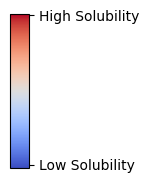

In [28]:
import matplotlib.cm as cm

fig_cbar, ax_cbar = plt.subplots(figsize=(0.25, 2))  # Adjust figsize to control size of colorbar

sc = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create a colorbar in the separate figure
cbar = plt.colorbar(sc, cax=ax_cbar, shrink = 0.5, ticks = [-0.7, 1.25])
cbar.set_ticklabels(["High Solubility", "Low Solubility"])
cbar.ax.invert_yaxis()
